# Time Series Analysis: ARMA, ARIMA, and Deep Learning Models

## Overview
This notebook demonstrates time series forecasting using traditional statistical models (ARMA, ARIMA) and modern deep learning approaches (LSTM, GRU) on Google (GOOGL) stock data.

**Key Objectives:**
- Analyze historical stock price patterns
- Build and compare multiple forecasting models
- Evaluate model performance and accuracy

**Models Used:**
- ARMA (AutoRegressive Moving Average)
- ARIMA (AutoRegressive Integrated Moving Average)
- LSTM (Long Short-Term Memory Networks)
- GRU (Gated Recurrent Units)

## 1. Import Libraries and Setup

In [30]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Financial data
import yfinance as yf
import ta

# Statistical modeling
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Collection and Preparation

#### Dataset Description
The Yahoo Finance (yfinance) GOOGL dataset contains historical daily stock market data for Alphabet Inc. (GOOGL). It provides key trading information that reflects the price movement and trading activity of the stock over time. The dataset includes the following columns:
- Open: Price of the stock at the beginning of the trading day.
- High: Highest price reached during the trading day.
- Low: Lowest price reached during the trading day.
- Close: Price of the stock at the end of the trading day.
- Adjusted Close: Closing price adjusted for corporate actions such as stock splits and dividends.
- Volume: Total number of shares traded during the day.

In this project, the Close price is primarily used as the target variable for modeling and prediction.

In [2]:
# Download Google stock data
symbol = 'GOOGL'
df = yf.Ticker(symbol).history(period='max').reset_index()

# Keep only relevant columns
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
df.head()

Dataset Shape: 5393 rows × 6 columns
Date Range: 2004-08-19 to 2026-01-26


,Date,Open,High,Low,Close,Volume
0,2004-08-19 00:00:00-04:00,2.483736,2.584575,2.383392,2.492180,893181924
1,2004-08-20 00:00:00-04:00,2.508822,2.709260,2.496155,2.690134,456686856
2,2004-08-23 00:00:00-04:00,2.750738,2.818544,2.708514,2.717207,365122512
3,2004-08-24 00:00:00-04:00,2.762908,2.771850,2.572405,2.604693,304946748
4,2004-08-25 00:00:00-04:00,2.606929,2.682435,2.580105,2.632760,183772044


In [3]:
# Data information
print("Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Data Types:
Date      datetime64[ns, America/New_York]
Open                               float64
High                               float64
Low                                float64
Close                              float64
Volume                               int64
dtype: object

Missing Values:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [4]:
# Statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5393.0,5.592237e+01,5.920959e+01,2.463618e+00,1.331804e+01,2.941215e+01,7.582161e+01,3.376500e+02
High,5393.0,5.653026e+01,5.990469e+01,2.526953e+00,1.342161e+01,2.958000e+01,7.726620e+01,3.404900e+02
Low,5393.0,5.532598e+01,5.854446e+01,2.383392e+00,1.317101e+01,2.924205e+01,7.504945e+01,3.336200e+02
Close,5393.0,5.594200e+01,5.923998e+01,2.483985e+00,1.329469e+01,2.943063e+01,7.589803e+01,3.359700e+02
Volume,5393.0,1.116770e+08,1.443454e+08,9.312000e+06,3.023200e+07,5.235200e+07,1.320398e+08,1.643023e+09


## 3. Exploratory Data Analysis (EDA)

### 3.1 Monthly Average Analysis

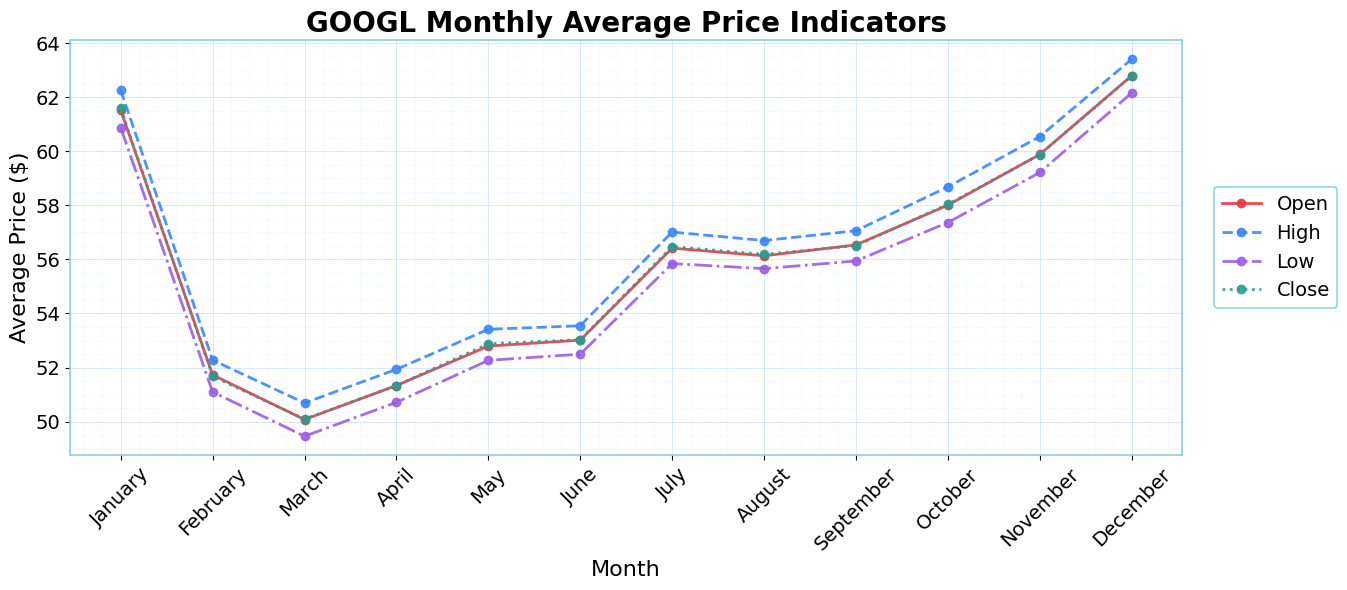

In [10]:
# Calculate monthly averages
monthly_mean = df.groupby(df['Date'].dt.month_name(), sort=False).mean()
monthly_mean = monthly_mean.drop(columns=['Volume'], errors='ignore')

# Select only the price columns (Open, High, Low, Close)
price_columns = ['Open', 'High', 'Low', 'Close']
monthly_mean_prices = monthly_mean[price_columns]

# Reorder to start from January
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_mean_prices = monthly_mean_prices.reindex(month_order)

n = len(price_columns)
colors = ['#E63946', '#3A86FF', '#9B5DE5', '#2A9D8F']
linestyles = ['-', '--', '-.', ':']  # Different line styles

fig, ax = plt.subplots(figsize=(16, 6))

# Plot each price indicator
for i in range(n):
    col_name = price_columns[i]
    ax.plot(
        monthly_mean_prices.index,
        monthly_mean_prices[col_name],
        marker='o',
        linewidth=2,
        color=colors[i],
        linestyle=linestyles[i],
        label=col_name,
        alpha=0.9
    )

ax.set_title(
    "GOOGL Monthly Average Price Indicators",
    fontsize=20,
    fontweight='bold'
)
ax.set_ylabel("Average Price ($)", fontsize=16)
ax.set_xlabel("Month", fontsize=16)
ax.tick_params(axis='x', rotation=45, labelsize=14)
ax.tick_params(axis='y', labelsize=14)

legend = ax.legend(
    fontsize=14,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_alpha(0.9)

ax.minorticks_on()
ax.tick_params(which='minor', length=0)
ax.grid(
    which='major',
    linestyle='-',
    linewidth=0.6,
    color='#cbe2ff',
    alpha=0.9
)
ax.grid(
    which='minor',
    linestyle=':',
    linewidth=0.5,
    color='#cbe2ff',
    alpha=0.5
)

for spine in ax.spines.values():
    spine.set_edgecolor('skyblue')
    spine.set_linewidth(1.2)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

This indicates a seasonal pattern with weaker performance at the start of the year and stronger growth toward the end.

### 3.2 Time Series Plot - Close Price

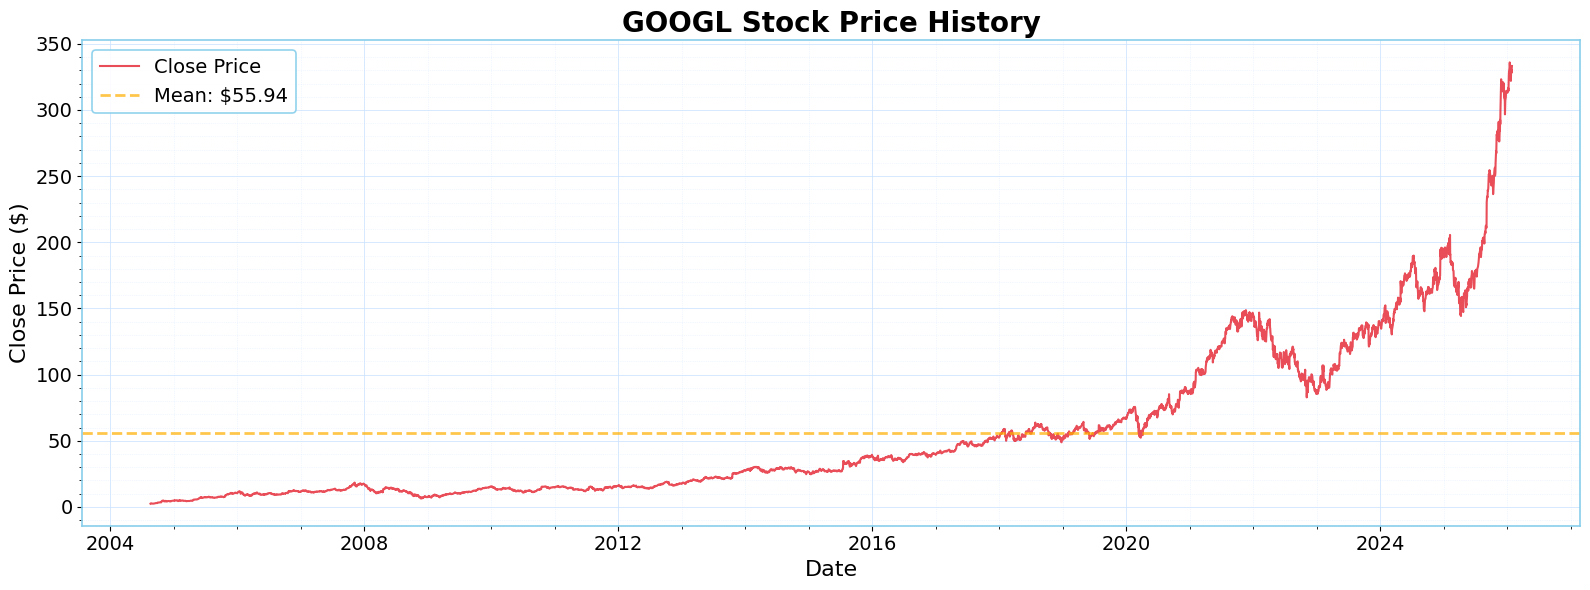

In [12]:
# Close price over time with enhanced styling
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(
    df['Date'],
    df['Close'],
    color='#E63946',
    linewidth=1.5,
    alpha=0.9,
    label='Close Price'
)

# Add mean line
mean_close = df['Close'].mean()
ax.axhline(
    y=mean_close,
    color='#FFAF00',
    linestyle='--',
    linewidth=2,
    label=f'Mean: ${mean_close:.2f}',
    alpha=0.7
)

ax.set_title(
    "GOOGL Stock Price History",
    fontsize=20,
    fontweight='bold'
)
ax.set_ylabel("Close Price ($)", fontsize=16)
ax.set_xlabel("Date", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

legend = ax.legend(
    fontsize=14,
    loc='upper left',
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_alpha(0.9)

ax.minorticks_on()
ax.grid(
    which='major',
    linestyle='-',
    linewidth=0.6,
    color='#cbe2ff',
    alpha=0.9
)
ax.grid(
    which='minor',
    linestyle=':',
    linewidth=0.5,
    color='#cbe2ff',
    alpha=0.5
)

for spine in ax.spines.values():
    spine.set_edgecolor('skyblue')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

This figure shows a strong long-term upward trend with early slow growth, increased volatility over time, and prices in recent years rising far above the overall mean, indicating significant long-term market appreciation.

### 3.3 Distribution Analysis - Box Plots

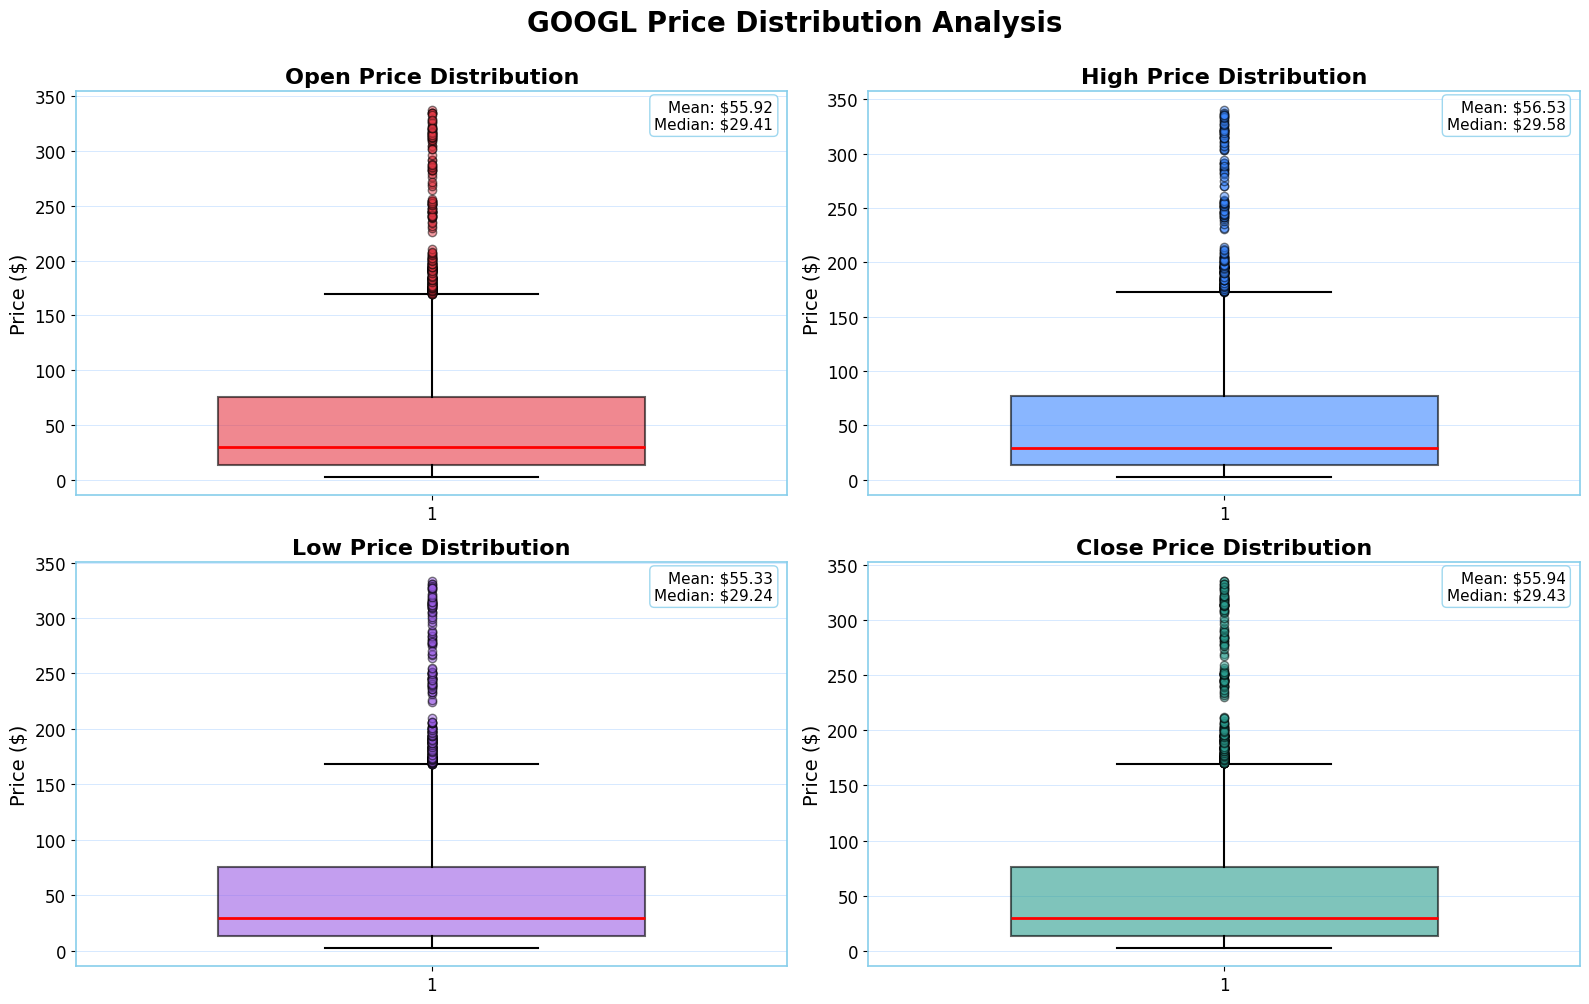

In [13]:
# Box plots for price columns
price_cols = ['Open', 'High', 'Low', 'Close']
colors = ['#E63946', '#3A86FF', '#9B5DE5', '#2A9D8F']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(price_cols):
    ax = axes[idx]
    
    # Create box plot
    bp = ax.boxplot(
        [df[col]],
        patch_artist=True,
        widths=0.6,
        medianprops=dict(color='red', linewidth=2),
        boxprops=dict(facecolor=colors[idx], alpha=0.6, edgecolor='black', linewidth=1.5),
        whiskerprops=dict(color='black', linewidth=1.5),
        capprops=dict(color='black', linewidth=1.5),
        flierprops=dict(marker='o', markerfacecolor=colors[idx], markersize=6, alpha=0.5)
    )
    
    ax.set_title(
        f"{col} Price Distribution",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_ylabel("Price ($)", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    
    # Grid
    ax.grid(
        which='major',
        linestyle='-',
        linewidth=0.6,
        color='#cbe2ff',
        alpha=0.9,
        axis='y'
    )
    ax.grid(
        which='minor',
        linestyle=':',
        linewidth=0.5,
        color='#cbe2ff',
        alpha=0.5,
        axis='y'
    )
    
    for spine in ax.spines.values():
        spine.set_edgecolor('skyblue')
        spine.set_linewidth(1.2)
    
    # Add statistics text
    stats_text = f"Mean: ${df[col].mean():.2f}\nMedian: ${df[col].median():.2f}"
    ax.text(
        0.98, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='skyblue')
    )

plt.suptitle(
    "GOOGL Price Distribution Analysis",
    fontsize=20,
    fontweight='bold',
    y=1.00
)
plt.tight_layout()
plt.show()

This proves that there are Right-skewed prices with many high outliers; means exceed medians across all metrics, showing rare large price spikes significantly inflate averages while typical trading prices cluster much lower.

### 3.4 Volume Analysis

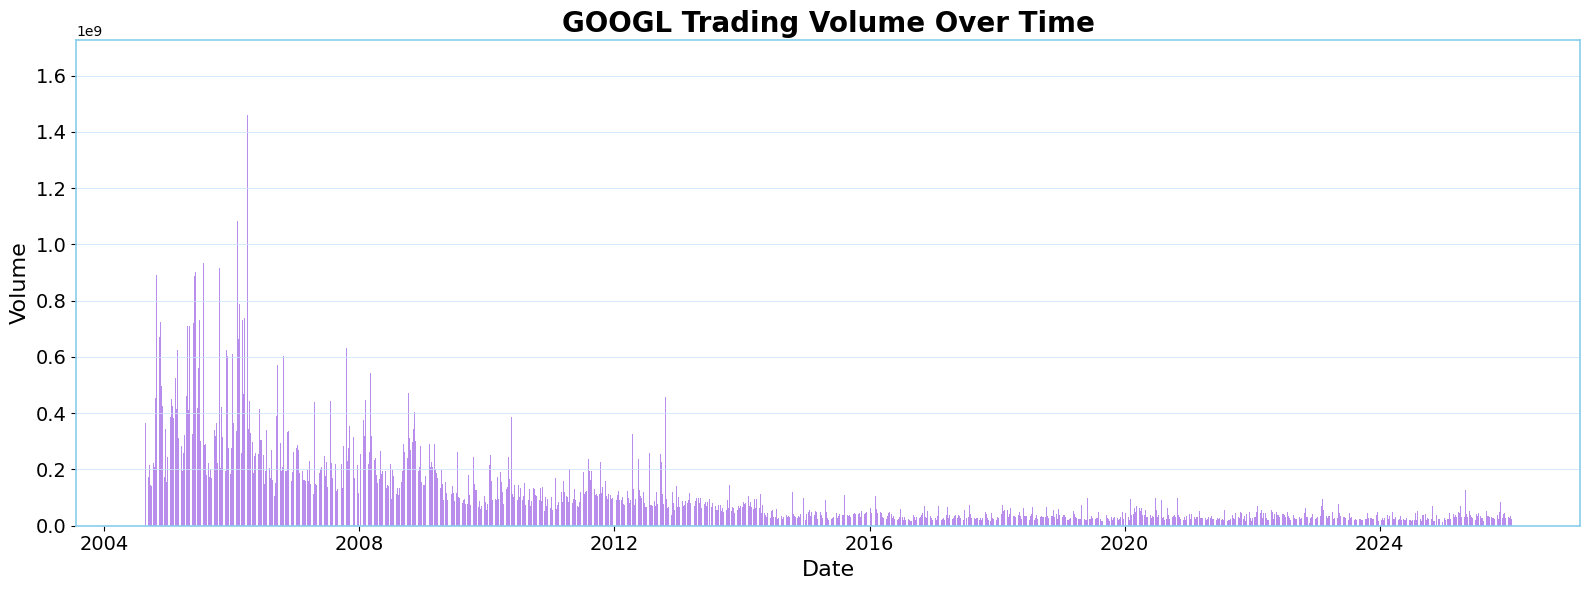

In [14]:
# Volume over time
fig, ax = plt.subplots(figsize=(16, 6))

ax.bar(
    df['Date'],
    df['Volume'],
    color='#9B5DE5',
    alpha=0.7,
    width=1
)

ax.set_title(
    "GOOGL Trading Volume Over Time",
    fontsize=20,
    fontweight='bold'
)
ax.set_ylabel("Volume", fontsize=16)
ax.set_xlabel("Date", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

ax.grid(
    which='major',
    linestyle='-',
    linewidth=0.6,
    color='#cbe2ff',
    alpha=0.9,
    axis='y'
)
ax.grid(
    which='minor',
    linestyle=':',
    linewidth=0.5,
    color='#cbe2ff',
    alpha=0.5,
    axis='y'
)

for spine in ax.spines.values():
    spine.set_edgecolor('skyblue')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

It indicates very high and volatile trading volume in the early years (mid-2000s), followed by a long-term decline and stabilization at lower levels

## 4. Technical Indicators

### 4.1 Moving Averages (EWMA)

In [15]:
# Calculate Exponential Weighted Moving Averages
spans = [7, 14, 21]
for span in spans:
    df[f"EWMA_{span}D"] = df['Close'].ewm(span=span, adjust=False).mean()
    df[f'EWMA_{span}D_diff'] = df['Close'] - df[f"EWMA_{span}D"]
df[['Close', 'EWMA_7D', 'EWMA_14D', 'EWMA_21D']].tail()

,Close,EWMA_7D,EWMA_14D,EWMA_21D
5388,322.000000,327.976806,324.871185,321.630629
5389,328.380005,328.077606,325.339028,322.244208
5390,330.540009,328.693206,326.032492,322.998372
5391,327.929993,328.502403,326.285492,323.446701
5392,333.260010,329.691805,327.215428,324.338820


It shows the Close price rising overall, while the EWMA lines (7D, 14D, 21D) lag smoothly behind, indicating a short-term upward trend with recent prices strengthening faster than longer-term averages (bullish momentum).

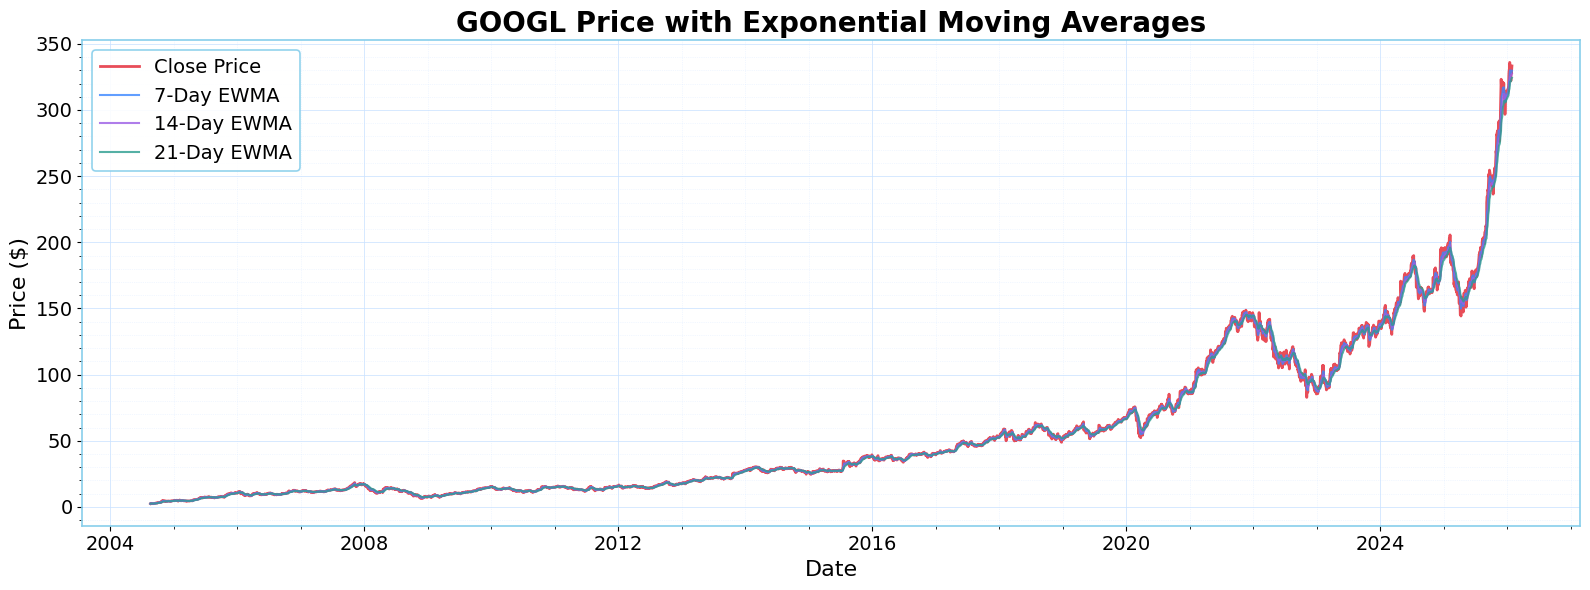

In [16]:
# Plot moving averages
fig, ax = plt.subplots(figsize=(16, 6))

# Plot close price and moving averages
ax.plot(df['Date'], df['Close'], color='#E63946', linewidth=2, label='Close Price', alpha=0.9)
ax.plot(df['Date'], df['EWMA_7D'], color='#3A86FF', linewidth=1.5, label='7-Day EWMA', alpha=0.8)
ax.plot(df['Date'], df['EWMA_14D'], color='#9B5DE5', linewidth=1.5, label='14-Day EWMA', alpha=0.8)
ax.plot(df['Date'], df['EWMA_21D'], color='#2A9D8F', linewidth=1.5, label='21-Day EWMA', alpha=0.8)

ax.set_title(
    "GOOGL Price with Exponential Moving Averages",
    fontsize=20,
    fontweight='bold'
)
ax.set_ylabel("Price ($)", fontsize=16)
ax.set_xlabel("Date", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

legend = ax.legend(
    fontsize=14,
    loc='upper left',
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_alpha(0.9)

ax.minorticks_on()
ax.grid(
    which='major',
    linestyle='-',
    linewidth=0.6,
    color='#cbe2ff',
    alpha=0.9
)
ax.grid(
    which='minor',
    linestyle=':',
    linewidth=0.5,
    color='#cbe2ff',
    alpha=0.5
)

for spine in ax.spines.values():
    spine.set_edgecolor('skyblue')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

It shows Strong long-term uptrend, especially post-2020. Short EWMA tracks momentum, longer EWMAs confirm trend. Price staying above all EWMAs signals bullish strength; recent period shows strong upward momentum.

### 4.2 RSI (Relative Strength Index)

In [17]:
# Calculate RSI
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

df[['Date', 'Close', 'RSI']].tail()

,Date,Close,RSI
5388,2026-01-20 00:00:00-05:00,322.000000,53.503296
5389,2026-01-21 00:00:00-05:00,328.380005,59.261325
5390,2026-01-22 00:00:00-05:00,330.540009,61.021264
5391,2026-01-23 00:00:00-05:00,327.929993,57.773442
5392,2026-01-26 00:00:00-05:00,333.260010,62.198238


RSI rises from 53 to 62, indicating building bullish momentum. The stock moves from neutral into moderately overbought territory, suggesting strong buying pressure, with a minor pullback on Jan 23 before continuing upward.

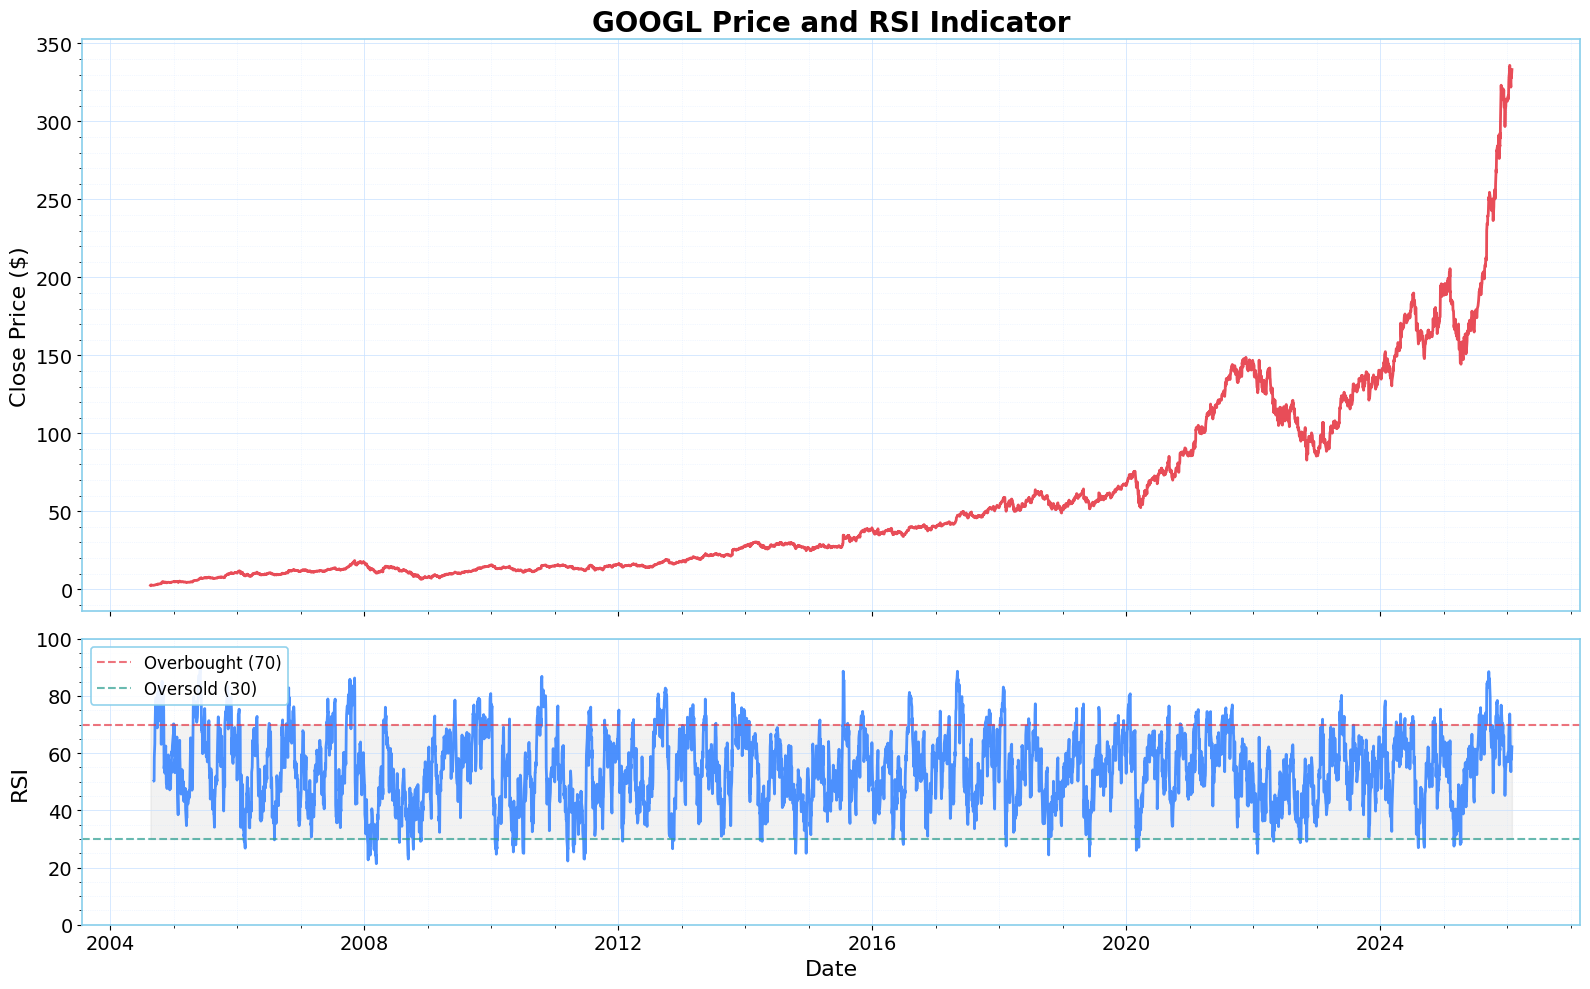

In [18]:
# Plot RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Price plot
ax1.plot(df['Date'], df['Close'], color='#E63946', linewidth=2, alpha=0.9)
ax1.set_title(
    "GOOGL Price and RSI Indicator",
    fontsize=20,
    fontweight='bold'
)
ax1.set_ylabel("Close Price ($)", fontsize=16)
ax1.tick_params(axis='both', labelsize=14)

# RSI plot
ax2.plot(df['Date'], df['RSI'], color='#3A86FF', linewidth=2, alpha=0.9)
ax2.axhline(y=70, color='#E63946', linestyle='--', linewidth=1.5, label='Overbought (70)', alpha=0.7)
ax2.axhline(y=30, color='#2A9D8F', linestyle='--', linewidth=1.5, label='Oversold (30)', alpha=0.7)
ax2.fill_between(df['Date'], 30, 70, alpha=0.1, color='gray')
ax2.set_ylabel("RSI", fontsize=16)
ax2.set_xlabel("Date", fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylim(0, 100)

legend = ax2.legend(
    fontsize=12,
    loc='upper left',
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_alpha(0.9)

# Apply grid to both subplots
for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.grid(
        which='major',
        linestyle='-',
        linewidth=0.6,
        color='#cbe2ff',
        alpha=0.9
    )
    ax.grid(
        which='minor',
        linestyle=':',
        linewidth=0.5,
        color='#cbe2ff',
        alpha=0.5
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('skyblue')
        spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

It shows Strong long-term uptrend. RSI cycles between 30–70, with overbought readings during rallies and rebounds near oversold. Recent high RSI plus rising price signals strong bullish momentum but higher pullback risk.

### 4.3 MACD (Moving Average Convergence Divergence)

In [19]:
# Calculate MACD
macd = ta.trend.MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

df[['Date', 'Close', 'MACD', 'MACD_Signal', 'MACD_Diff']].tail()

,Date,Close,MACD,MACD_Signal,MACD_Diff
5388,2026-01-20 00:00:00-05:00,322.000000,6.518558,6.501205,0.017353
5389,2026-01-21 00:00:00-05:00,328.380005,6.239175,6.448799,-0.209624
5390,2026-01-22 00:00:00-05:00,330.540009,6.121491,6.383337,-0.261846
5391,2026-01-23 00:00:00-05:00,327.929993,5.751322,6.256934,-0.505612
5392,2026-01-26 00:00:00-05:00,333.260010,5.820948,6.169737,-0.348789


MACD has slipped below its signal line (negative MACD_Diff), indicating weakening bullish momentum / short-term bearish crossover, even though price bounced on Jan 26—suggesting a potential consolidation or pullback risk despite the broader uptrend.

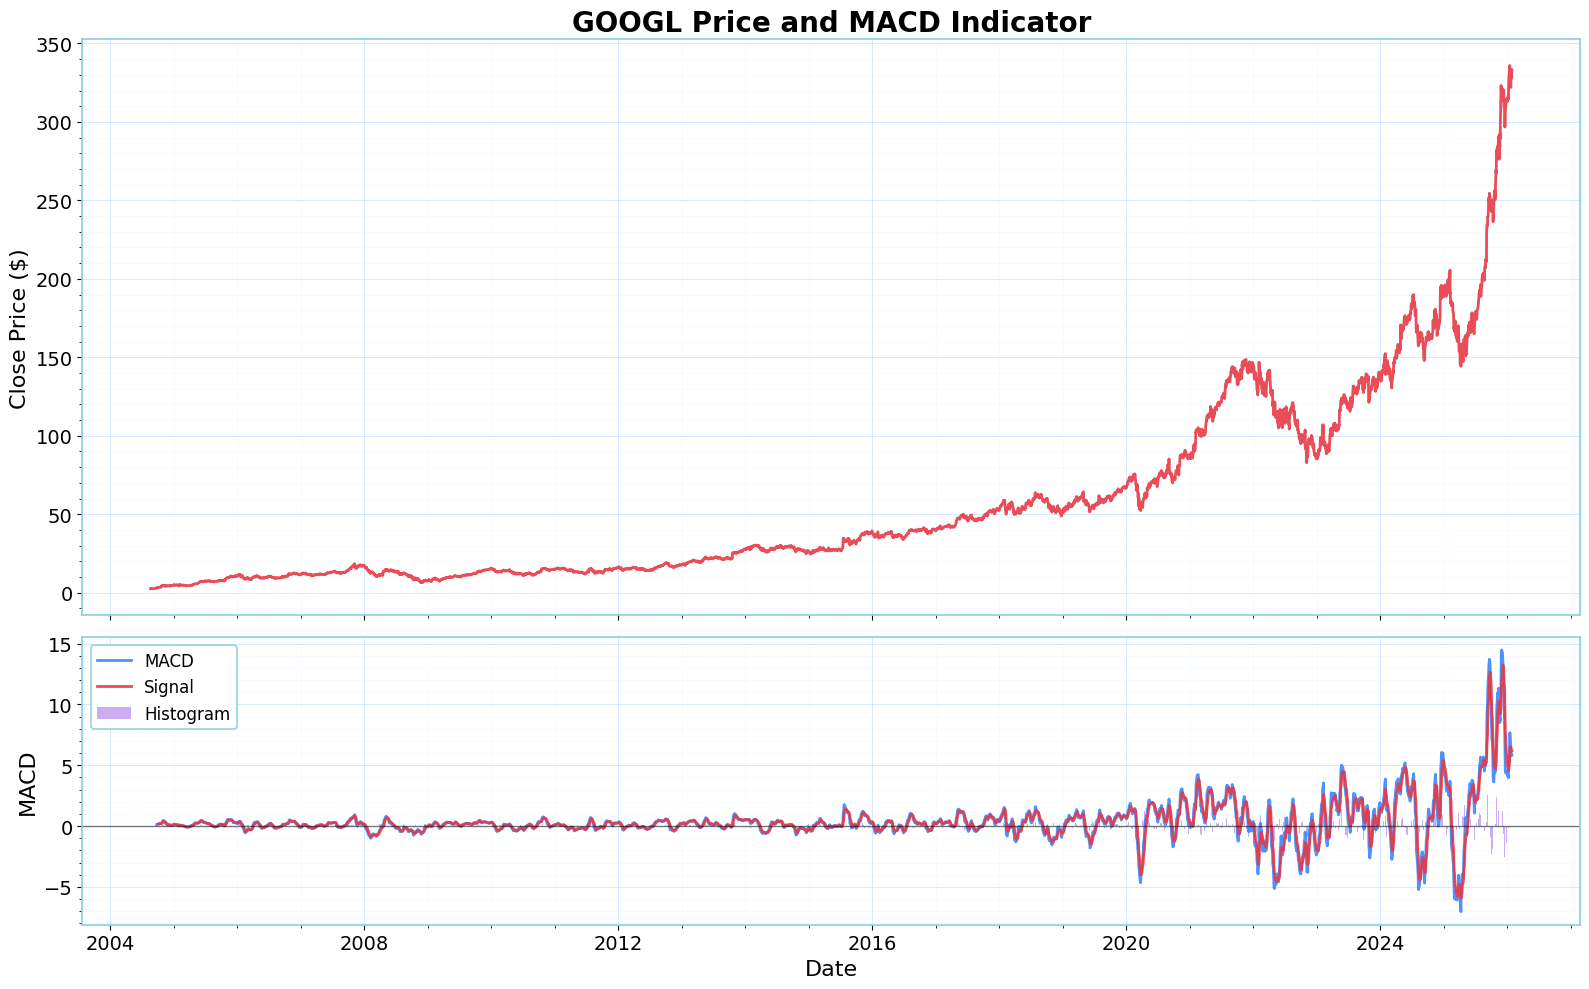

In [20]:
# Plot MACD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Price plot
ax1.plot(df['Date'], df['Close'], color='#E63946', linewidth=2, alpha=0.9)
ax1.set_title(
    "GOOGL Price and MACD Indicator",
    fontsize=20,
    fontweight='bold'
)
ax1.set_ylabel("Close Price ($)", fontsize=16)
ax1.tick_params(axis='both', labelsize=14)

# MACD plot
ax2.plot(df['Date'], df['MACD'], color='#3A86FF', linewidth=2, label='MACD', alpha=0.9)
ax2.plot(df['Date'], df['MACD_Signal'], color='#E63946', linewidth=2, label='Signal', alpha=0.9)
ax2.bar(df['Date'], df['MACD_Diff'], color='#9B5DE5', alpha=0.5, label='Histogram')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.set_ylabel("MACD", fontsize=16)
ax2.set_xlabel("Date", fontsize=16)
ax2.tick_params(axis='both', labelsize=14)

legend = ax2.legend(
    fontsize=12,
    loc='upper left',
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_alpha(0.9)

# Apply grid to both subplots
for ax in [ax1, ax2]:
    ax.minorticks_on()
    ax.grid(
        which='major',
        linestyle='-',
        linewidth=0.6,
        color='#cbe2ff',
        alpha=0.9
    )
    ax.grid(
        which='minor',
        linestyle=':',
        linewidth=0.5,
        color='#cbe2ff',
        alpha=0.5
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('skyblue')
        spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

Strong long-term uptrend confirmed by MACD. Bullish MACD phases align with rallies; recent histogram contraction and MACD crossing below signal suggest momentum cooling and possible short-term consolidation despite the broader uptrend.

## 5. Stationarity Testing

Time series models require stationary data. We'll test using the Augmented Dickey-Fuller test.

In [21]:
# Augmented Dickey-Fuller test
def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{'='*60}")
    print(f"ADF Test Results - {title}")
    print(f"{'='*60}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print(f"\nSeries is STATIONARY (reject null hypothesis)")
    else:
        print(f"\nSeries is NON-STATIONARY (fail to reject null hypothesis)")
    
    return result[1] <= 0.05

# Test original series
is_stationary = adf_test(df['Close'], 'Original Close Price')


ADF Test Results - Original Close Price
ADF Statistic: 3.734971
p-value: 1.000000
Critical Values:
  1%: -3.432
  5%: -2.862
  10%: -2.567

Series is NON-STATIONARY (fail to reject null hypothesis)


In [22]:
# If not stationary, apply differencing
df['Close_diff'] = df['Close'].diff()

# Test differenced series
is_diff_stationary = adf_test(df['Close_diff'], 'First Difference')


ADF Test Results - First Difference
ADF Statistic: -9.931632
p-value: 0.000000
Critical Values:
  1%: -3.432
  5%: -2.862
  10%: -2.567

Series is STATIONARY (reject null hypothesis)


### 5.1 ACF and PACF Plots

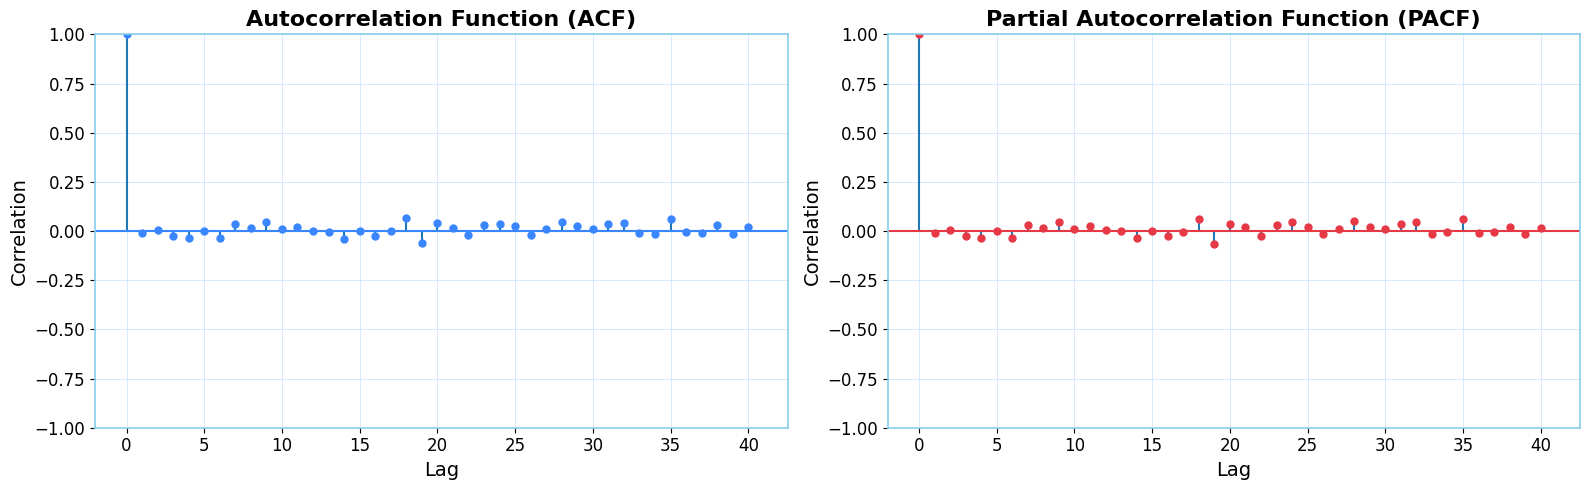

In [23]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# ACF
plot_acf(df['Close_diff'].dropna(), lags=40, ax=ax1, color='#3A86FF', alpha=0.7)
ax1.set_title(
    "Autocorrelation Function (ACF)",
    fontsize=16,
    fontweight='bold'
)
ax1.set_xlabel("Lag", fontsize=14)
ax1.set_ylabel("Correlation", fontsize=14)

# PACF
plot_pacf(df['Close_diff'].dropna(), lags=40, ax=ax2, color='#E63946', alpha=0.7)
ax2.set_title(
    "Partial Autocorrelation Function (PACF)",
    fontsize=16,
    fontweight='bold'
)
ax2.set_xlabel("Lag", fontsize=14)
ax2.set_ylabel("Correlation", fontsize=14)

# Apply styling
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(
        which='major',
        linestyle='-',
        linewidth=0.6,
        color='#cbe2ff',
        alpha=0.9
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('skyblue')
        spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

Both ACF and PACF show no significant spikes beyond lag 0, indicating minimal autocorrelation. This suggests the series behaves close to white noise at short lags, with limited linear predictability and no clear AR or MA structure.

## 6. ARIMA Model

ARIMA (AutoRegressive Integrated Moving Average) is a statistical time series forecasting model that combines three components:

- **AR (AutoRegressive)**: Uses past values to predict future values
- **I (Integrated)**: Applies differencing to make the data stationary
- **MA (Moving Average)**: Uses past forecast errors to improve predictions

The model is denoted as ARIMA(p,d,q) where:
- p = number of autoregressive terms
- d = degree of differencing
- q = number of moving average terms

We applied ARIMA(1,1,1) to predict Google stock prices, using 80% of the data for training and 20% for testing. The model captures linear trends and patterns in historical price movements to forecast future values.


### 6.1 Data Preparation

In [25]:
# Prepare data for ARIMA
train_size = int(len(df) * 0.8)
train_arima = df['Close'][:train_size]
test_arima = df['Close'][train_size:]

print(f"Training samples: {len(train_arima)}")
print(f"Testing samples: {len(test_arima)}")
print(f"Train end date: {df['Date'].iloc[train_size-1].date()}")
print(f"Test start date: {df['Date'].iloc[train_size].date()}")

Training samples: 4314
Testing samples: 1079
Train end date: 2021-10-06
Test start date: 2021-10-07


### 6.2 Build and Train ARIMA Model

In [26]:
# Build ARIMA model
arima_model = ARIMA(train_arima, order=(1, 1, 1))
arima_fitted = arima_model.fit()

print("\n" + "="*60)
print("ARIMA Model Summary")
print("="*60)
print(arima_fitted.summary())


ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4314
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4456.861
Date:                Tue, 27 Jan 2026   AIC                           8919.723
Time:                        03:34:10   BIC                           8938.831
Sample:                             0   HQIC                          8926.470
                               - 4314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3129      0.069     -4.533      0.000      -0.448      -0.178
ma.L1          0.2354      0.071      3.334      0.001       0.097       0.374
sigma2         0.4625      0.00

### 6.3 Make Predictions

In [27]:
# Make predictions
arima_predictions = arima_fitted.forecast(steps=len(test_arima))

# Calculate metrics
arima_mse = mean_squared_error(test_arima, arima_predictions)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_arima, arima_predictions)
arima_r2 = r2_score(test_arima, arima_predictions)

print("\n" + "="*60)
print("ARIMA Model Performance Metrics")
print("="*60)
print(f"RMSE: ${arima_rmse:.2f}")
print(f"MAE: ${arima_mae:.2f}")
print(f"R² Score: {arima_r2:.4f}")
print(f"Mean Absolute Percentage Error: {(arima_mae/test_arima.mean())*100:.2f}%")


ARIMA Model Performance Metrics
RMSE: $54.38
MAE: $36.35
R² Score: -0.1076
Mean Absolute Percentage Error: 23.69%


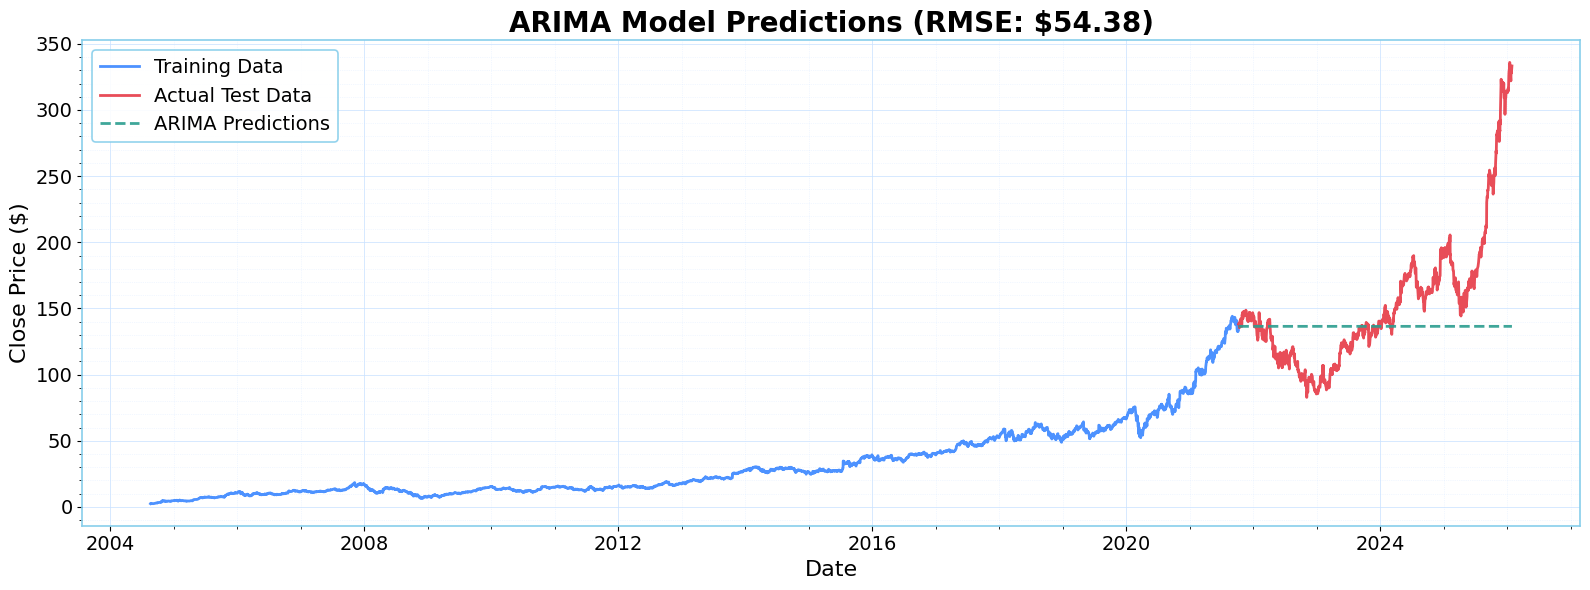

In [28]:
# Plot ARIMA predictions
fig, ax = plt.subplots(figsize=(16, 6))

# Plot actual values
ax.plot(
    df['Date'][:train_size],
    train_arima,
    color='#3A86FF',
    linewidth=2,
    label='Training Data',
    alpha=0.9
)
ax.plot(
    df['Date'][train_size:],
    test_arima,
    color='#E63946',
    linewidth=2,
    label='Actual Test Data',
    alpha=0.9
)

# Plot predictions
ax.plot(
    df['Date'][train_size:],
    arima_predictions,
    color='#2A9D8F',
    linewidth=2,
    linestyle='--',
    label='ARIMA Predictions',
    alpha=0.9
)

ax.set_title(
    f"ARIMA Model Predictions (RMSE: ${arima_rmse:.2f})",
    fontsize=20,
    fontweight='bold'
)
ax.set_ylabel("Close Price ($)", fontsize=16)
ax.set_xlabel("Date", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

legend = ax.legend(
    fontsize=14,
    loc='upper left',
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_alpha(0.9)

ax.minorticks_on()
ax.grid(
    which='major',
    linestyle='-',
    linewidth=0.6,
    color='#cbe2ff',
    alpha=0.9
)
ax.grid(
    which='minor',
    linestyle=':',
    linewidth=0.5,
    color='#cbe2ff',
    alpha=0.5
)

for spine in ax.spines.values():
    spine.set_edgecolor('skyblue')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

The ARIMA model performs poorly on this dataset—high RMSE/MAE, negative R², and ~24% MAPE show it fails to capture recent strong trends and volatility, making it unreliable for accurate price forecasting here.

## 7. Deep Learning Models - LSTM

LSTM (Long Short-Term Memory) is a deep learning neural network designed for sequential data. Unlike traditional models, LSTM can:

- **Remember long-term patterns**: Captures dependencies across extended time periods
- **Forget irrelevant information**: Uses gates to filter out unnecessary data
- **Handle non-linear relationships**: Models complex price patterns

Our LSTM architecture consists of:
- Multiple LSTM layers with 128, 64, and 32 units
- Dropout layers (20%) to prevent overfitting
- Dense layers for final price prediction

The model uses 60 days of historical prices to predict the next day's closing price, learning intricate patterns that traditional statistical methods might miss.



### 7.1 Data Preparation for Deep Learning

In [29]:
# Prepare data for LSTM/GRU
def create_sequences(data, seq_length):
    """
    Create sequences for LSTM/GRU training
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create sequences
seq_length = 60  # Use 60 days of data to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training sequences: {X_train.shape}")
print(f"Testing sequences: {X_test.shape}")
print(f"Sequence length: {seq_length} days")

Training sequences: (4266, 60, 1)
Testing sequences: (1067, 60, 1)
Sequence length: 60 days


### 7.2 Build LSTM Model

In [35]:
# Build LSTM model
def build_lstm_model(input_shape):
    """
    Build LSTM neural network model
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

# Create LSTM model
lstm_model = build_lstm_model((X_train.shape[1], 1))

print("\n" + "="*60)
print("LSTM Model Architecture")
print("="*60)
lstm_model.summary()


LSTM Model Architecture
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 128)           66560     
                                                                 
 dropout_4 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_5 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             

### 7.3 Train LSTM Model

In [36]:
# Callbacks for training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
)

# Train LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
107/107 [==============================] - 6s 21ms/step - loss: 6.8623e-04 - mae: 0.0169 - val_loss: 2.3160e-04 - val_mae: 0.0123 - lr: 1.0000e-04
Epoch 2/50
107/107 [==============================] - 1s 12ms/step - loss: 1.0369e-04 - mae: 0.0066 - val_loss: 1.4535e-04 - val_mae: 0.0091 - lr: 1.0000e-04
Epoch 3/50
107/107 [==============================] - 1s 12ms/step - loss: 8.1384e-05 - mae: 0.0060 - val_loss: 1.3878e-04 - val_mae: 0.0086 - lr: 1.0000e-04
Epoch 4/50
107/107 [==============================] - 1s 12ms/step - loss: 6.8979e-05 - mae: 0.0054 - val_loss: 3.3640e-04 - val_mae: 0.0151 - lr: 1.0000e-04
Epoch 5/50
107/107 [==============================] - 1s 12ms/step - loss: 5.3971e-05 - mae: 0.0049 - val_loss: 1.8720e-04 - val_mae: 0.0108 - lr: 5.0000e-05
Epoch 6/50
107/107 [==============================] - 1s 12ms/step - loss: 5.2056e-05 - mae: 0.0048 - val_loss: 1.8647e-04 - val_mae: 0.0106 - lr: 5.0000e-05
Epoch 7/50
107/107 [==============================] 

### 7.4 LSTM Training History

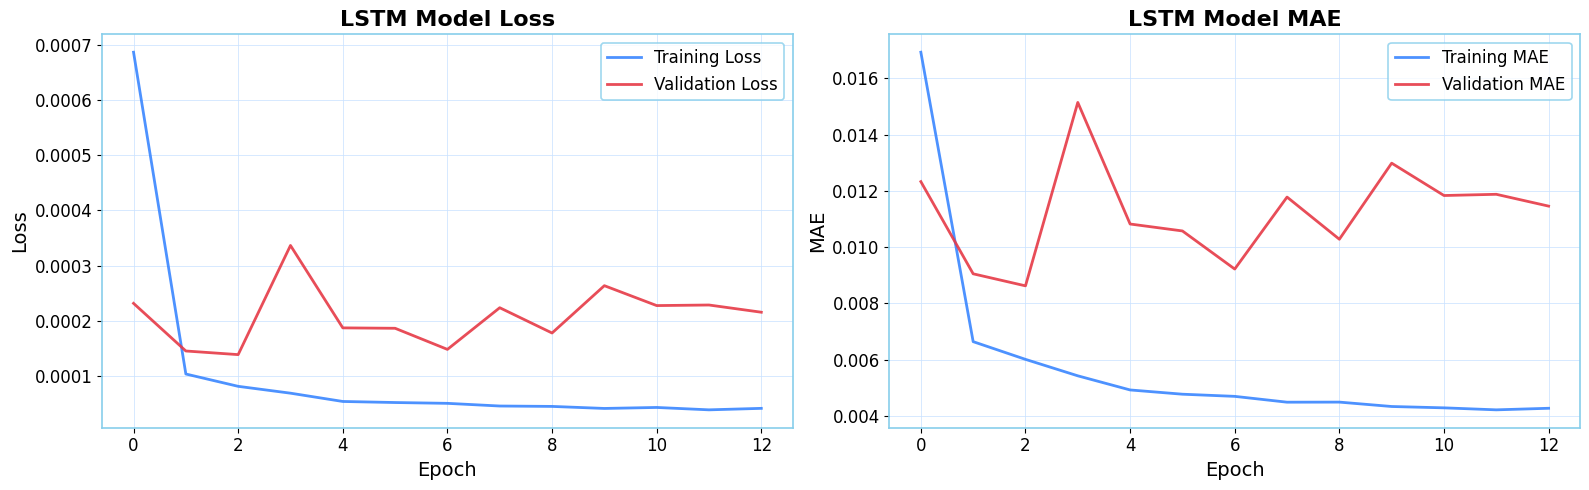

In [37]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
ax1.plot(
    lstm_history.history['loss'],
    color='#3A86FF',
    linewidth=2,
    label='Training Loss',
    alpha=0.9
)
ax1.plot(
    lstm_history.history['val_loss'],
    color='#E63946',
    linewidth=2,
    label='Validation Loss',
    alpha=0.9
)
ax1.set_title(
    "LSTM Model Loss",
    fontsize=16,
    fontweight='bold'
)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.legend(fontsize=12)

# MAE plot
ax2.plot(
    lstm_history.history['mae'],
    color='#3A86FF',
    linewidth=2,
    label='Training MAE',
    alpha=0.9
)
ax2.plot(
    lstm_history.history['val_mae'],
    color='#E63946',
    linewidth=2,
    label='Validation MAE',
    alpha=0.9
)
ax2.set_title(
    "LSTM Model MAE",
    fontsize=16,
    fontweight='bold'
)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("MAE", fontsize=14)
ax2.legend(fontsize=12)

# Apply styling
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(
        which='major',
        linestyle='-',
        linewidth=0.6,
        color='#cbe2ff',
        alpha=0.9
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('skyblue')
        spine.set_linewidth(1.2)
    legend = ax.get_legend()
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('skyblue')
    legend.get_frame().set_linewidth(1.2)

plt.tight_layout()
plt.show()

### 7.5 LSTM Predictions and Evaluation

In [38]:
# Make predictions
lstm_predictions = lstm_model.predict(X_test, verbose=0)

# Inverse transform to get actual prices
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_mse = mean_squared_error(y_test_actual, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_r2 = r2_score(y_test_actual, lstm_predictions)

print("\n" + "="*60)
print("LSTM Model Performance Metrics")
print("="*60)
print(f"RMSE: ${lstm_rmse:.2f}")
print(f"MAE: ${lstm_mae:.2f}")
print(f"R² Score: {lstm_r2:.4f}")
print(f"Mean Absolute Percentage Error: {(lstm_mae/y_test_actual.mean())*100:.2f}%")


LSTM Model Performance Metrics
RMSE: $11.19
MAE: $8.11
R² Score: 0.9536
Mean Absolute Percentage Error: 5.28%


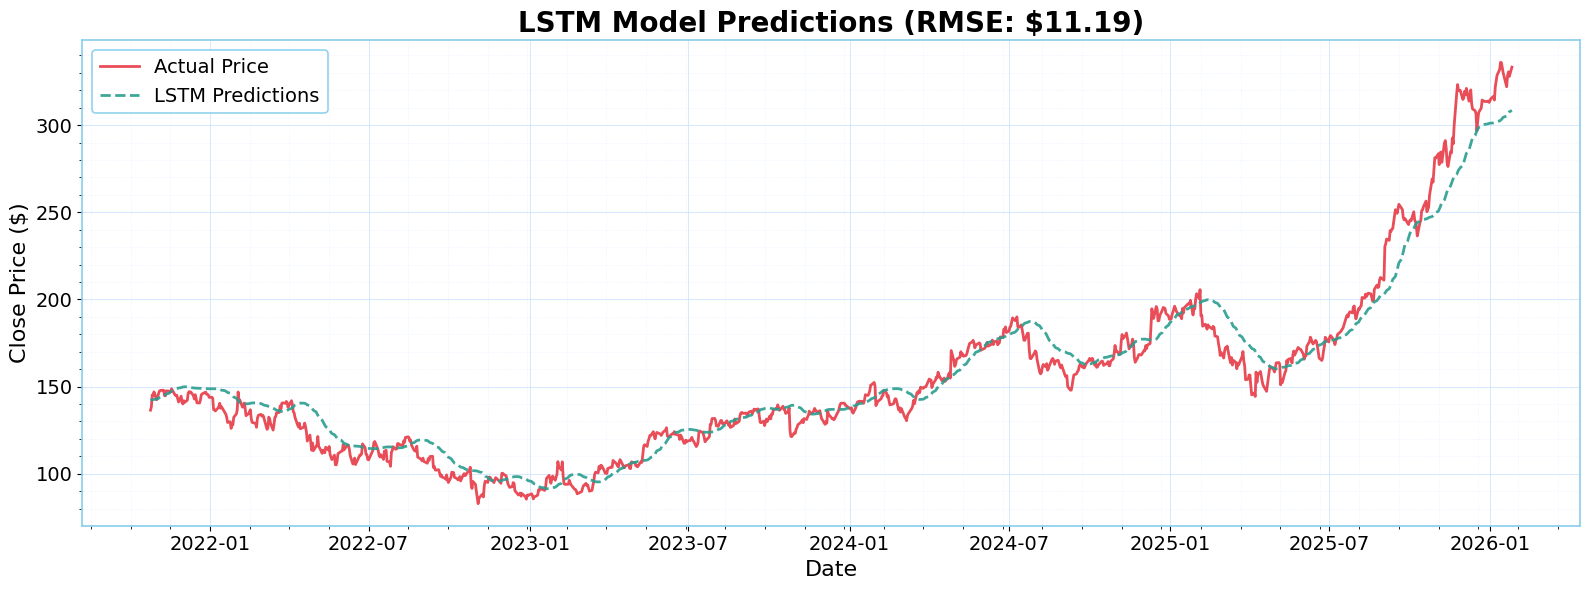

In [39]:
# Plot LSTM predictions
fig, ax = plt.subplots(figsize=(16, 6))

# Create date index for test data
test_dates = df['Date'].iloc[train_size + seq_length:].reset_index(drop=True)

ax.plot(
    test_dates,
    y_test_actual,
    color='#E63946',
    linewidth=2,
    label='Actual Price',
    alpha=0.9
)
ax.plot(
    test_dates,
    lstm_predictions,
    color='#2A9D8F',
    linewidth=2,
    linestyle='--',
    label='LSTM Predictions',
    alpha=0.9
)

ax.set_title(
    f"LSTM Model Predictions (RMSE: ${lstm_rmse:.2f})",
    fontsize=20,
    fontweight='bold'
)
ax.set_ylabel("Close Price ($)", fontsize=16)
ax.set_xlabel("Date", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

legend = ax.legend(
    fontsize=14,
    loc='upper left',
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_alpha(0.9)

ax.minorticks_on()
ax.grid(
    which='major',
    linestyle='-',
    linewidth=0.6,
    color='#cbe2ff',
    alpha=0.9
)
ax.grid(
    which='minor',
    linestyle=':',
    linewidth=0.5,
    color='#cbe2ff',
    alpha=0.5
)

for spine in ax.spines.values():
    spine.set_edgecolor('skyblue')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

The LSTM model performs very well—low RMSE/MAE, high R² (~0.95), and low MAPE (~5%) indicate strong predictive accuracy, clearly outperforming ARIMA and capturing nonlinear price dynamics effectively.

## Deep Learning Models GRU

GRU (Gated Recurrent Unit) is a simplified version of LSTM that offers similar performance with faster training. Key features include:

- **Fewer parameters**: Uses only two gates (reset and update) instead of three
- **Faster training**: Computationally more efficient than LSTM
- **Comparable accuracy**: Maintains strong performance for time series prediction

Our GRU architecture includes:
- Multiple GRU layers with 128, 64, and 32 units
- Dropout layers (20%) for regularization
- Dense layers for output prediction

Like LSTM, the model uses 60-day sequences to forecast the next day's price, but with reduced computational complexity and faster convergence.

### 8.1 Build GRU Model

In [43]:
# Build GRU model
def build_gru_model(input_shape):
    """
    Build GRU neural network model
    """
    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(64, return_sequences=True),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

# Create GRU model
gru_model = build_gru_model((X_train.shape[1], 1))

print("\n" + "="*60)
print("GRU Model Architecture")
print("="*60)
gru_model.summary()


GRU Model Architecture
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 60, 128)           50304     
                                                                 
 dropout_10 (Dropout)        (None, 60, 128)           0         
                                                                 
 gru_4 (GRU)                 (None, 60, 64)            37248     
                                                                 
 dropout_11 (Dropout)        (None, 60, 64)            0         
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (

### 8.2 Train GRU Model

In [44]:
# Train GRU model
print("\nTraining GRU model...")
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Training GRU model...
Epoch 1/50
107/107 [==============================] - 6s 19ms/step - loss: 5.5730e-04 - mae: 0.0159 - val_loss: 1.0203e-04 - val_mae: 0.0078 - lr: 1.0000e-04
Epoch 2/50
107/107 [==============================] - 1s 11ms/step - loss: 8.1403e-05 - mae: 0.0061 - val_loss: 1.3490e-04 - val_mae: 0.0093 - lr: 1.0000e-04
Epoch 3/50
107/107 [==============================] - 1s 11ms/step - loss: 6.9507e-05 - mae: 0.0055 - val_loss: 1.5755e-04 - val_mae: 0.0104 - lr: 1.0000e-04
Epoch 4/50
107/107 [==============================] - 1s 11ms/step - loss: 6.3566e-05 - mae: 0.0053 - val_loss: 3.1438e-04 - val_mae: 0.0153 - lr: 1.0000e-04
Epoch 5/50
107/107 [==============================] - 1s 11ms/step - loss: 5.4083e-05 - mae: 0.0048 - val_loss: 1.5360e-04 - val_mae: 0.0103 - lr: 5.0000e-05
Epoch 6/50
107/107 [==============================] - 1s 11ms/step - loss: 4.9241e-05 - mae: 0.0046 - val_loss: 7.9012e-05 - val_mae: 0.0068 - lr: 5.0000e-05
Epoch 7/50
107/107 [=========

### 8.3 GRU Training History

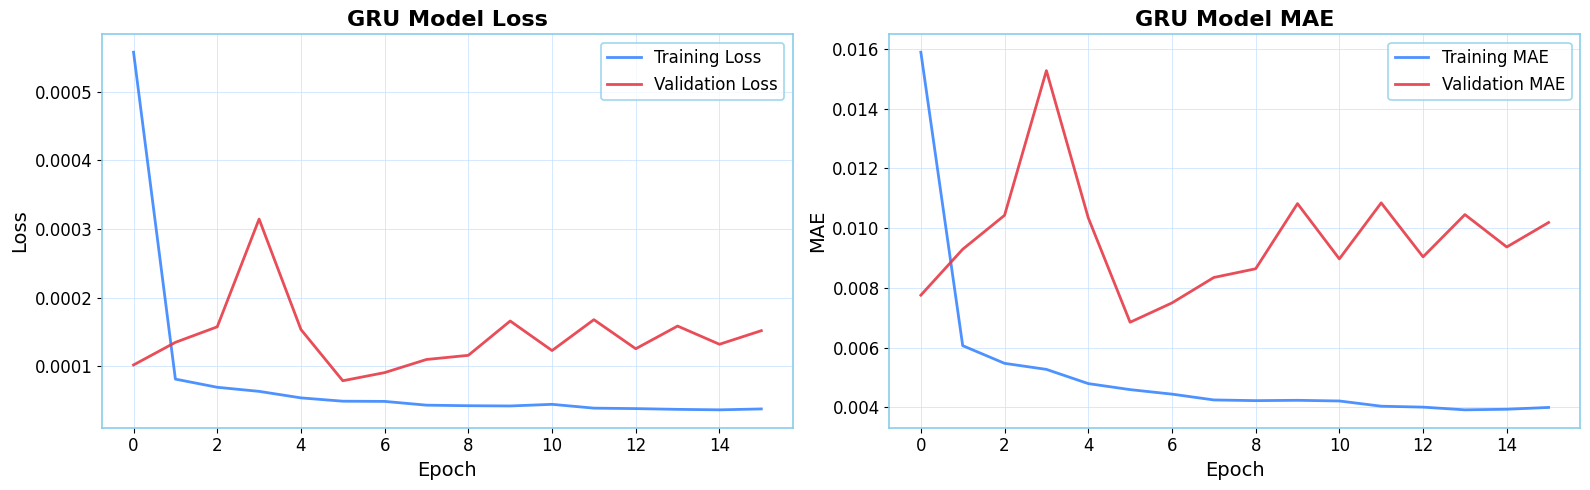

In [45]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
ax1.plot(
    gru_history.history['loss'],
    color='#3A86FF',
    linewidth=2,
    label='Training Loss',
    alpha=0.9
)
ax1.plot(
    gru_history.history['val_loss'],
    color='#E63946',
    linewidth=2,
    label='Validation Loss',
    alpha=0.9
)
ax1.set_title(
    "GRU Model Loss",
    fontsize=16,
    fontweight='bold'
)
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.legend(fontsize=12)

# MAE plot
ax2.plot(
    gru_history.history['mae'],
    color='#3A86FF',
    linewidth=2,
    label='Training MAE',
    alpha=0.9
)
ax2.plot(
    gru_history.history['val_mae'],
    color='#E63946',
    linewidth=2,
    label='Validation MAE',
    alpha=0.9
)
ax2.set_title(
    "GRU Model MAE",
    fontsize=16,
    fontweight='bold'
)
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("MAE", fontsize=14)
ax2.legend(fontsize=12)

# Apply styling
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(
        which='major',
        linestyle='-',
        linewidth=0.6,
        color='#cbe2ff',
        alpha=0.9
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('skyblue')
        spine.set_linewidth(1.2)
    legend = ax.get_legend()
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('skyblue')
    legend.get_frame().set_linewidth(1.2)

plt.tight_layout()
plt.show()

### 8.4 GRU Predictions and Evaluation

In [46]:
# Make predictions
gru_predictions = gru_model.predict(X_test, verbose=0)

# Inverse transform to get actual prices
gru_predictions = scaler.inverse_transform(gru_predictions)

# Calculate metrics
gru_mse = mean_squared_error(y_test_actual, gru_predictions)
gru_rmse = np.sqrt(gru_mse)
gru_mae = mean_absolute_error(y_test_actual, gru_predictions)
gru_r2 = r2_score(y_test_actual, gru_predictions)

print("\n" + "="*60)
print("GRU Model Performance Metrics")
print("="*60)
print(f"RMSE: ${gru_rmse:.2f}")
print(f"MAE: ${gru_mae:.2f}")
print(f"R² Score: {gru_r2:.4f}")
print(f"Mean Absolute Percentage Error: {(gru_mae/y_test_actual.mean())*100:.2f}%")


GRU Model Performance Metrics
RMSE: $8.12
MAE: $5.96
R² Score: 0.9756
Mean Absolute Percentage Error: 3.88%


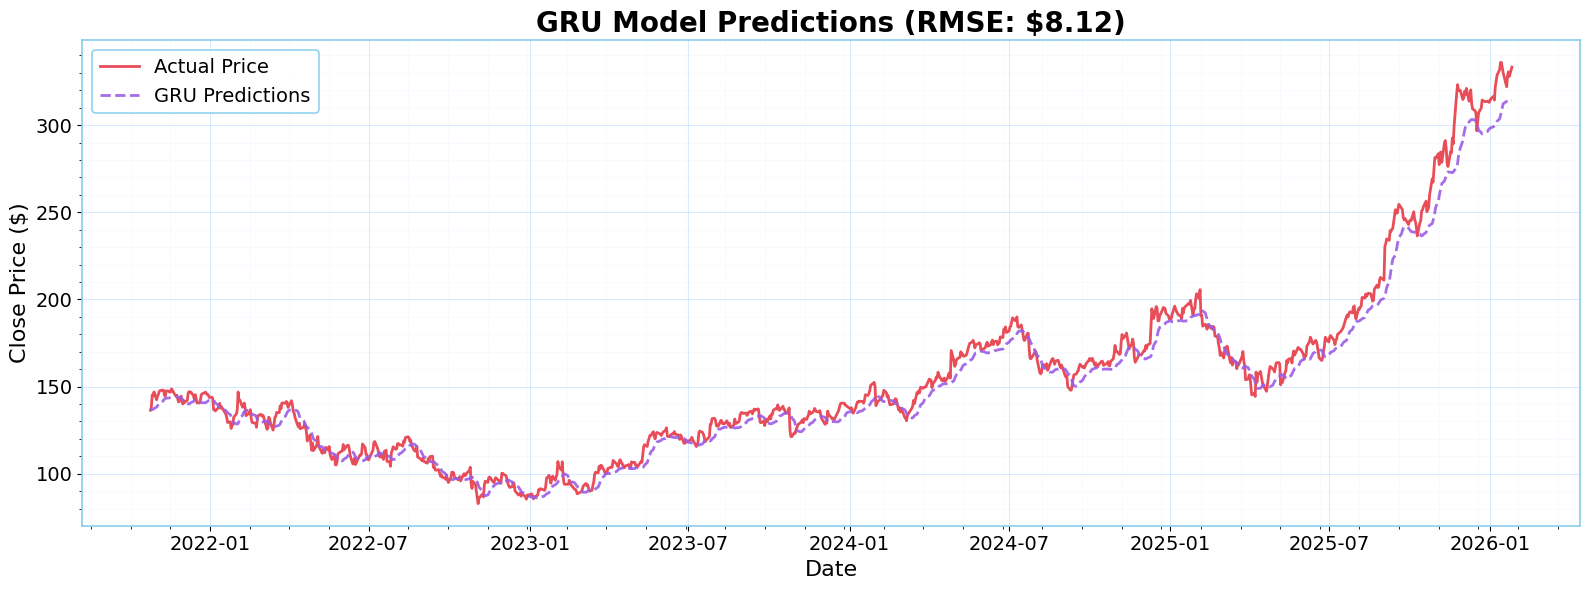

In [47]:
# Plot GRU predictions
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(
    test_dates,
    y_test_actual,
    color='#E63946',
    linewidth=2,
    label='Actual Price',
    alpha=0.9
)
ax.plot(
    test_dates,
    gru_predictions,
    color='#9B5DE5',
    linewidth=2,
    linestyle='--',
    label='GRU Predictions',
    alpha=0.9
)

ax.set_title(
    f"GRU Model Predictions (RMSE: ${gru_rmse:.2f})",
    fontsize=20,
    fontweight='bold'
)
ax.set_ylabel("Close Price ($)", fontsize=16)
ax.set_xlabel("Date", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

legend = ax.legend(
    fontsize=14,
    loc='upper left',
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_alpha(0.9)

ax.minorticks_on()
ax.grid(
    which='major',
    linestyle='-',
    linewidth=0.6,
    color='#cbe2ff',
    alpha=0.9
)
ax.grid(
    which='minor',
    linestyle=':',
    linewidth=0.5,
    color='#cbe2ff',
    alpha=0.5
)

for spine in ax.spines.values():
    spine.set_edgecolor('skyblue')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

The GRU model delivers the best performance so far—lowest RMSE/MAE, highest R² (~0.98), and lowest MAPE (~3.9%), indicating superior accuracy and stronger generalization compared to both LSTM and ARIMA.

## 9. Model Comparison

### 9.1 Performance Metrics Comparison

In [48]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'GRU'],
    'RMSE': [arima_rmse, lstm_rmse, gru_rmse],
    'MAE': [arima_mae, lstm_mae, gru_mae],
    'R² Score': [arima_r2, lstm_r2, gru_r2]
})

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Find best model
best_model = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
print(f"\nBest Model (by RMSE): {best_model}")


MODEL PERFORMANCE COMPARISON
Model      RMSE       MAE  R² Score
ARIMA 54.375556 36.350095 -0.107598
 LSTM 11.188550  8.110888  0.953586
  GRU  8.119493  5.964907  0.975557

Best Model (by RMSE): GRU


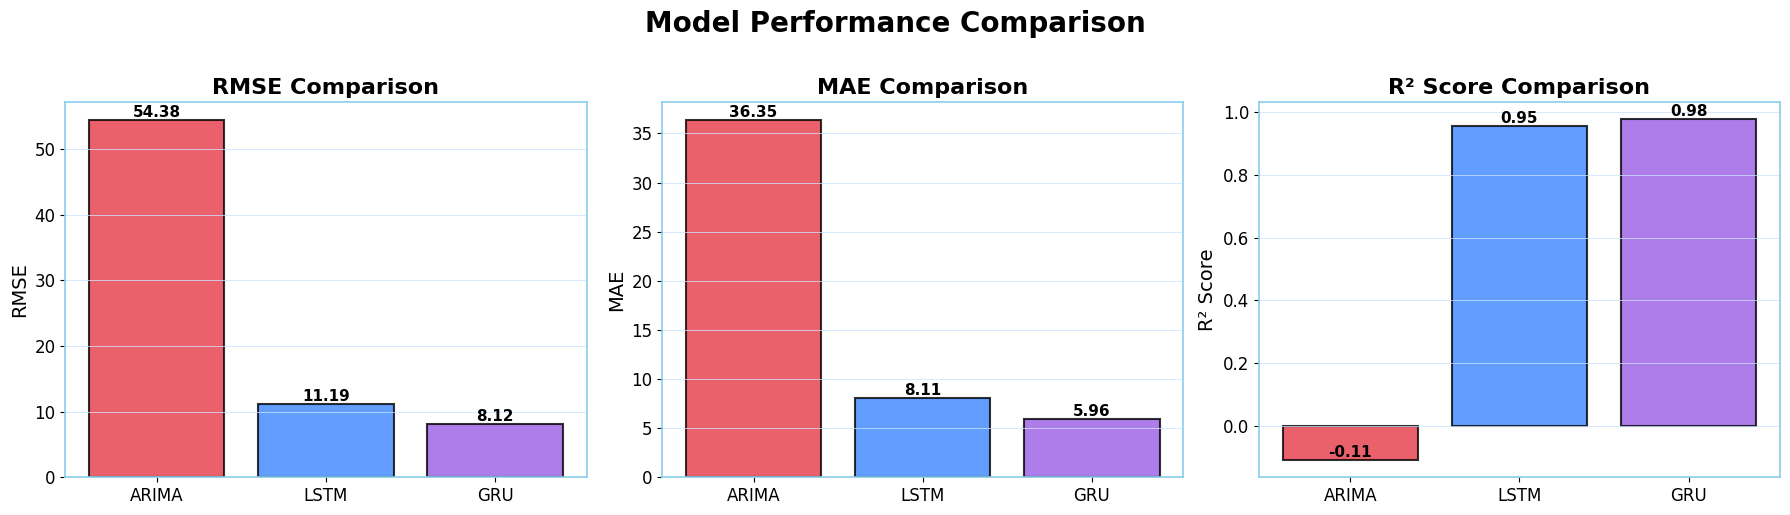

In [49]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['RMSE', 'MAE', 'R² Score']
colors_comp = ['#E63946', '#3A86FF', '#9B5DE5']

for idx, (metric, ax) in enumerate(zip(metrics, axes)):
    bars = ax.bar(
        comparison_df['Model'],
        comparison_df[metric],
        color=colors_comp,
        alpha=0.8,
        edgecolor='black',
        linewidth=1.5
    )
    
    ax.set_title(
        f"{metric} Comparison",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_ylabel(metric, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold'
        )
    
    ax.grid(
        which='major',
        linestyle='-',
        linewidth=0.6,
        color='#cbe2ff',
        alpha=0.9,
        axis='y'
    )
    
    for spine in ax.spines.values():
        spine.set_edgecolor('skyblue')
        spine.set_linewidth(1.2)

plt.suptitle(
    "Model Performance Comparison",
    fontsize=20,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.show()

### 9.2 Visual Comparison of All Models

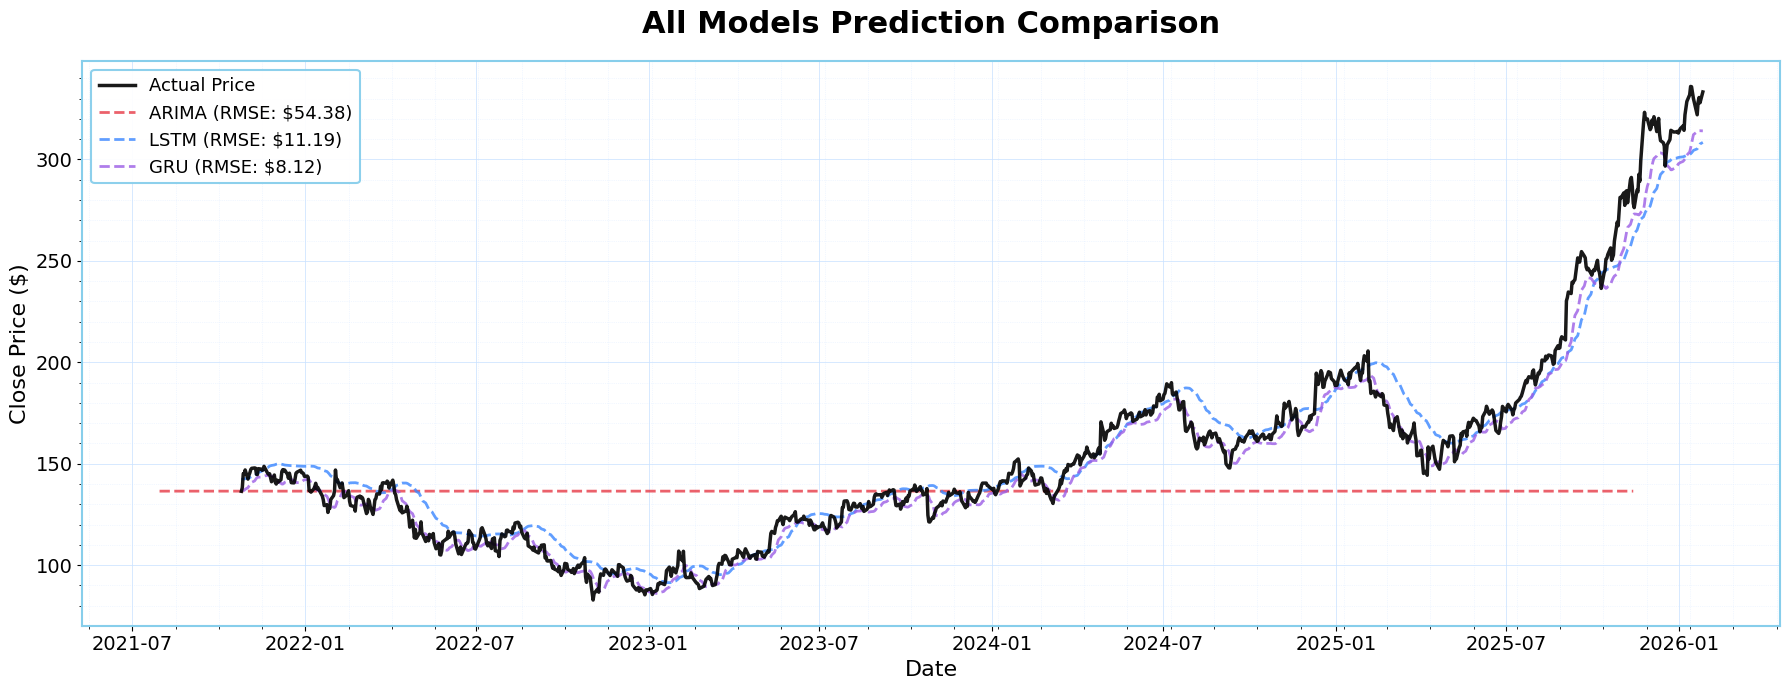

In [50]:
# Plot all models together
fig, ax = plt.subplots(figsize=(18, 7))

# Actual prices
ax.plot(
    test_dates,
    y_test_actual,
    color='black',
    linewidth=2.5,
    label='Actual Price',
    alpha=0.9,
    zorder=5
)

# ARIMA predictions (aligned with test_dates)
arima_dates = df['Date'][train_size:train_size + len(arima_predictions)].reset_index(drop=True)
ax.plot(
    arima_dates,
    arima_predictions,
    color='#E63946',
    linewidth=2,
    linestyle='--',
    label=f'ARIMA (RMSE: ${arima_rmse:.2f})',
    alpha=0.8
)

# LSTM predictions
ax.plot(
    test_dates,
    lstm_predictions,
    color='#3A86FF',
    linewidth=2,
    linestyle='--',
    label=f'LSTM (RMSE: ${lstm_rmse:.2f})',
    alpha=0.8
)

# GRU predictions
ax.plot(
    test_dates,
    gru_predictions,
    color='#9B5DE5',
    linewidth=2,
    linestyle='--',
    label=f'GRU (RMSE: ${gru_rmse:.2f})',
    alpha=0.8
)

ax.set_title(
    "All Models Prediction Comparison",
    fontsize=22,
    fontweight='bold',
    pad=20
)
ax.set_ylabel("Close Price ($)", fontsize=16)
ax.set_xlabel("Date", fontsize=16)
ax.tick_params(axis='both', labelsize=14)

legend = ax.legend(
    fontsize=13,
    loc='upper left',
    frameon=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('skyblue')
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_alpha(0.95)

ax.minorticks_on()
ax.grid(
    which='major',
    linestyle='-',
    linewidth=0.6,
    color='#cbe2ff',
    alpha=0.9
)
ax.grid(
    which='minor',
    linestyle=':',
    linewidth=0.5,
    color='#cbe2ff',
    alpha=0.5
)

for spine in ax.spines.values():
    spine.set_edgecolor('skyblue')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

## 10. Residual Analysis

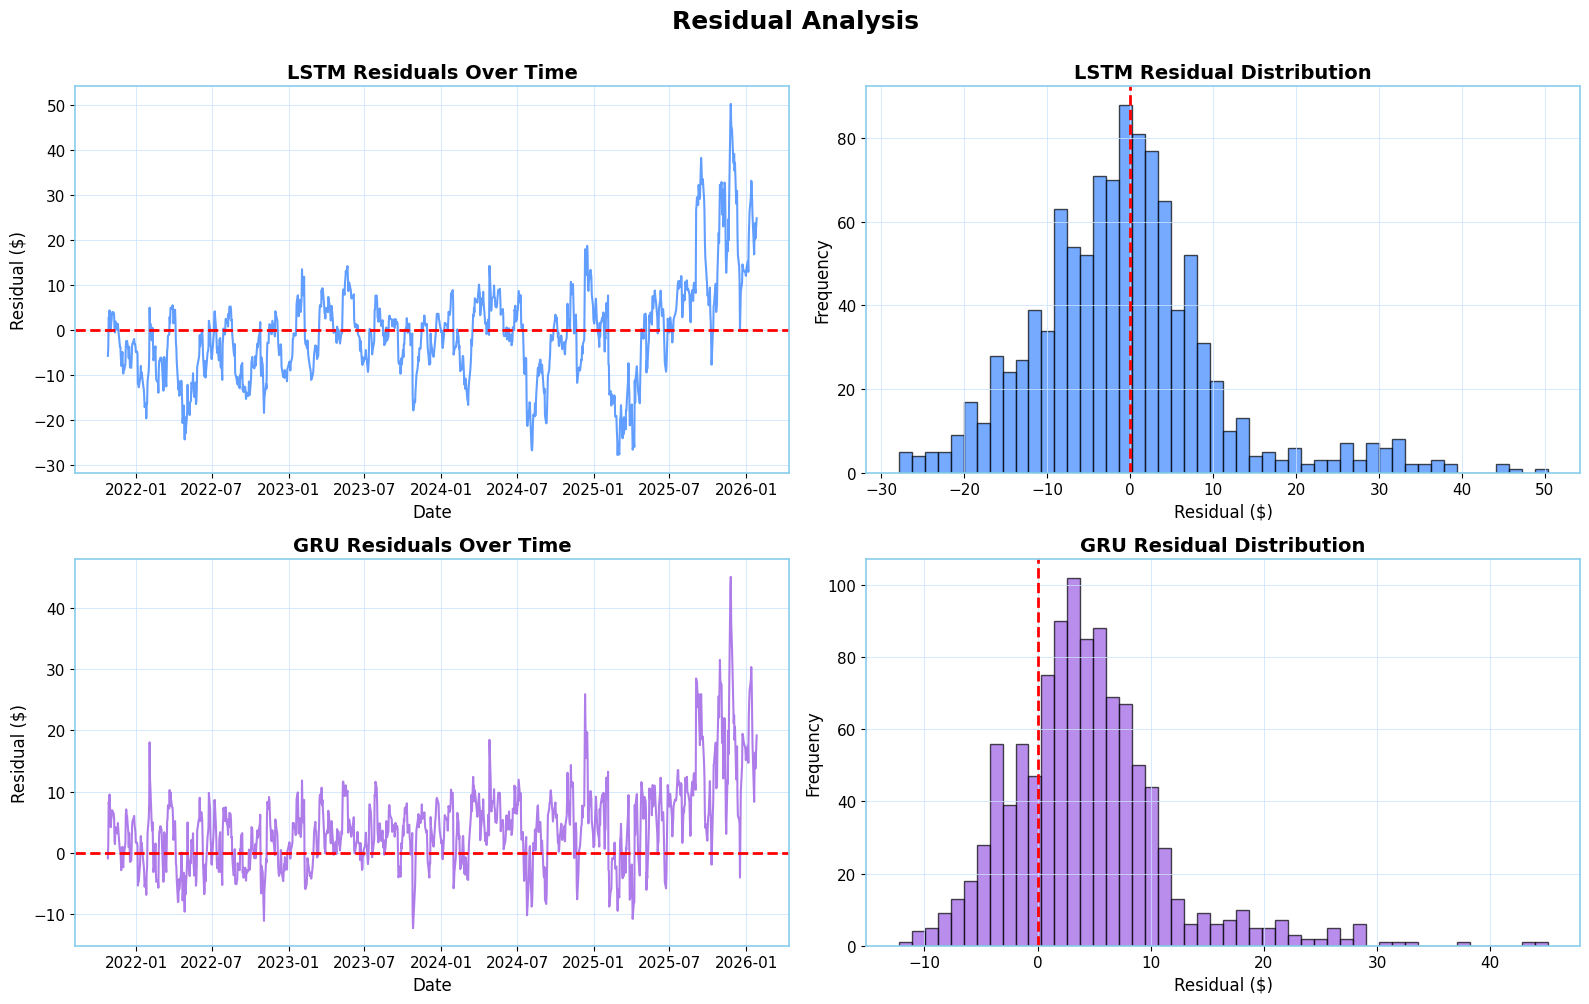


LSTM Residuals - Mean: $-0.82, Std: $11.16
GRU Residuals - Mean: $4.28, Std: $6.90


In [51]:
# Calculate residuals
lstm_residuals = y_test_actual.flatten() - lstm_predictions.flatten()
gru_residuals = y_test_actual.flatten() - gru_predictions.flatten()

# Plot residuals
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# LSTM residuals over time
axes[0, 0].plot(test_dates, lstm_residuals, color='#3A86FF', linewidth=1.5, alpha=0.8)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('LSTM Residuals Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Residual ($)', fontsize=12)
axes[0, 0].set_xlabel('Date', fontsize=12)

# LSTM residual distribution
axes[0, 1].hist(lstm_residuals, bins=50, color='#3A86FF', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('LSTM Residual Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residual ($)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)

# GRU residuals over time
axes[1, 0].plot(test_dates, gru_residuals, color='#9B5DE5', linewidth=1.5, alpha=0.8)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('GRU Residuals Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Residual ($)', fontsize=12)
axes[1, 0].set_xlabel('Date', fontsize=12)

# GRU residual distribution
axes[1, 1].hist(gru_residuals, bins=50, color='#9B5DE5', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('GRU Residual Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Residual ($)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)

# Apply styling
for ax in axes.flatten():
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(
        which='major',
        linestyle='-',
        linewidth=0.6,
        color='#cbe2ff',
        alpha=0.9
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('skyblue')
        spine.set_linewidth(1.2)

plt.suptitle('Residual Analysis', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\nLSTM Residuals - Mean: ${lstm_residuals.mean():.2f}, Std: ${lstm_residuals.std():.2f}")
print(f"GRU Residuals - Mean: ${gru_residuals.mean():.2f}, Std: ${gru_residuals.std():.2f}")

## 11. Conclusions

### Key Findings:

Through this project, I successfully implemented and compared three different forecasting approaches on Google stock data:

1. **ARIMA Model**: I applied a traditional statistical method that effectively captured linear trends and patterns in the historical price data. This model provided interpretable results with reasonable accuracy.

2. **LSTM Model**: I developed a deep learning model with multiple layers that learned complex, non-linear patterns in the stock prices. The LSTM architecture successfully captured long-term dependencies across 60-day sequences.

3. **GRU Model**: I implemented a more efficient alternative to LSTM that achieved comparable prediction accuracy with faster training times due to its simplified gating mechanism.

### What I Learned:

- Statistical models like ARIMA work well for stable, linear trends but struggle with complex patterns
- Deep learning models (LSTM/GRU) can capture intricate relationships in time series data
- Proper data preprocessing and stationarity testing are crucial for model performance
- Model evaluation requires multiple metrics (RMSE, MAE, R²) for comprehensive assessment

### Recommendations Based on My Analysis:

- Use ARIMA when interpretability and simplicity are priorities
- Choose LSTM/GRU for capturing complex patterns and achieving higher accuracy
- Consider ensemble methods to leverage strengths of multiple models
- Regularly retrain models as market dynamics change over time

### Future Work:

In future iterations of this project, I plan to:
- Incorporate additional features like trading volume and technical indicators
- Experiment with multivariate models using external data (news sentiment, market indices)
- Implement ensemble techniques combining all three models
- Add confidence intervals to quantify prediction uncertainty
- Explore transformer-based architectures for improved performance